# Mountain Car with Linear Function Approximation

In [1]:
using ReinforcementLearningBase, ReinforcementLearningEnvironments
using Plots; gr(); 
import StatsBase.sample
env = MountainCarEnv();

Firstly, we will define tillings:

In [2]:
tilling(S,n,offset) = [(i,j) for i in range(S[1].left + offset,S[1].right + offset, length = n + 1), 
        j in range(S[2].left + offset,S[2].right + offset, length = n + 1)] 

tillings(S,n,m) = [tilling(S,n,i/n) for i = 0:m-1]

between(x,a,b) = a ≤ x < b 

code(s,t::Array{Tuple{Float64,Float64},2}) = [between(s[1],t[i,j][1],t[i+1,j][1]) && between(s[2],t[i,j][2],t[i,j+1][2])
      for j = 1:size(t,2)-1 for i = 1:size(t,1)-1]

code(s,tillings::Array{Array{Tuple{Float64,Float64},2},1}) = 
                vcat([code(s,t) for t in tillings]...)


code (generic function with 2 methods)

Then Agent:

In [3]:
mutable struct Agent
    env::AbstractEnv
    ϵ::Float64
    ϵ_decay::Float64
    ϵ_min::Float64
    β::Float64
    η::Float64
    tillings::Array{Array{Tuple{Float64,Float64},2},1}
    W::Array{Float64,2}
    position::Float64
    reward::Float64
end

Agent(env, n, m, ϵ = 1.0, ϵ_decay = 0.9975, 
    ϵ_min = 0.005, β = 0.99, η = 0.02) = Agent(env, ϵ, ϵ_decay, ϵ_min, β, η,
                                                tillings(state_space(env), n, m),
                                                rand(length(action_space(env)), n*n*m),
                                                -Inf, 0.0)

Agent

Finally, functions that control the learning process:

In [4]:
policy(agent::Agent, state::Array{Bool,1}) = argmax(agent.W * state)

policy (generic function with 1 method)

In [5]:
function step!(agent::Agent, train::Bool)
    s = code(deepcopy(state(agent.env)), agent.tillings)
    (rand() < agent.ϵ  && train) ? (a = rand(agent.env.action_space)) : (a = policy(agent, s))
    agent.env(a)
    r, s′, terminal = deepcopy(reward(agent.env)), deepcopy(state(agent.env)), deepcopy(is_terminated(agent.env))
    agent.position = s′[1]
    s′ = code(s′,agent.tillings)
    agent.reward += r
    if train
        if terminal
            R  = r
        else
            Q_new_state = agent.W * s′
            rand() < agent.ϵ ?  R = r + agent.β * rand(Q_new_state) :
            R = r + agent.β * Q_new_state[policy(agent,s′)]
        end
        Q_hat = agent.W * s
        Q = deepcopy(Q_hat)
        Q[a] = R
        agent.W += agent.η*(Q .- Q_hat) * transpose(s)
    end
    terminal 
end

step! (generic function with 1 method)

In [6]:
function run!(agent::Agent, episodes::Int; train::Bool = true, plotting::Bool = true, summary::Bool = true)
    rewards = []
    success_rates = []
    ep = 1.0
    success = 0.0
    while ep ≤ episodes
        plotting && (plot(agent.env); sleep(0.0001))
        if step!(agent, train) 
            reset!(agent.env)
            agent.position > 0.5 && (success += 1.0)
            push!(rewards, agent.reward)
            push!(success_rates, success/ep)
            if summary
                println("episode $(Int(ep)) ends! Reward: $(agent.reward)")
                println("ϵ: $(agent.ϵ), success rate: $(success/ep)")
            end
            ep += 1.0
            agent.reward = 0.0
            agent.position = -Inf
            eps = agent.ϵ * agent.ϵ_decay
            agent.ϵ = max(agent.ϵ_min, eps)
        end
    end
    return rewards, success_rates
end

run! (generic function with 1 method)

## Experiment

In [14]:
agent = Agent(env,8,4);

Before Learning:

In [15]:
#rewards,_ = run!(agent,10; train = false, plotting = true);

After Learning:

In [16]:
rewards, success_rates = run!(agent,5_000; plotting = false);
#rewards,_ = run!(agent,10; train = false, plotting = true);

episode 1 ends! Reward: -199.0
ϵ: 1.0, success rate: 0.0
episode 2 ends! Reward: -199.0
ϵ: 0.9975, success rate: 0.0
episode 3 ends! Reward: -199.0
ϵ: 0.9950062500000001, success rate: 0.0
episode 4 ends! Reward: -199.0
ϵ: 0.9925187343750002, success rate: 0.0
episode 5 ends! Reward: -199.0
ϵ: 0.9900374375390627, success rate: 0.0
episode 6 ends! Reward: -199.0
ϵ: 0.9875623439452151, success rate: 0.0
episode 7 ends! Reward: -199.0
ϵ: 0.9850934380853521, success rate: 0.0
episode 8 ends! Reward: -199.0
ϵ: 0.9826307044901388, success rate: 0.0
episode 9 ends! Reward: -199.0
ϵ: 0.9801741277289134, success rate: 0.0
episode 10 ends! Reward: -199.0
ϵ: 0.9777236924095912, success rate: 0.0
episode 11 ends! Reward: -199.0
ϵ: 0.9752793831785673, success rate: 0.0
episode 12 ends! Reward: -199.0
ϵ: 0.972841184720621, success rate: 0.0
episode 13 ends! Reward: -199.0
ϵ: 0.9704090817588195, success rate: 0.0
episode 14 ends! Reward: -199.0
ϵ: 0.9679830590544225, success rate: 0.0
episode 15 ends

episode 130 ends! Reward: -199.0
ϵ: 0.7240435053514873, success rate: 0.0
episode 131 ends! Reward: -199.0
ϵ: 0.7222333965881086, success rate: 0.0
episode 132 ends! Reward: -199.0
ϵ: 0.7204278130966384, success rate: 0.0
episode 133 ends! Reward: -199.0
ϵ: 0.7186267435638969, success rate: 0.0
episode 134 ends! Reward: -199.0
ϵ: 0.7168301767049872, success rate: 0.0
episode 135 ends! Reward: -199.0
ϵ: 0.7150381012632248, success rate: 0.0
episode 136 ends! Reward: -199.0
ϵ: 0.7132505060100668, success rate: 0.0
episode 137 ends! Reward: -199.0
ϵ: 0.7114673797450417, success rate: 0.0
episode 138 ends! Reward: -199.0
ϵ: 0.7096887112956791, success rate: 0.0
episode 139 ends! Reward: -199.0
ϵ: 0.70791448951744, success rate: 0.0
episode 140 ends! Reward: -199.0
ϵ: 0.7061447032936464, success rate: 0.0
episode 141 ends! Reward: -199.0
ϵ: 0.7043793415354124, success rate: 0.0
episode 142 ends! Reward: -199.0
ϵ: 0.7026183931815739, success rate: 0.0
episode 143 ends! Reward: -199.0
ϵ: 0.70

ϵ: 0.5375269965546731, success rate: 0.0
episode 250 ends! Reward: -199.0
ϵ: 0.5361831790632864, success rate: 0.0
episode 251 ends! Reward: -199.0
ϵ: 0.5348427211156283, success rate: 0.0
episode 252 ends! Reward: -199.0
ϵ: 0.5335056143128392, success rate: 0.0
episode 253 ends! Reward: -199.0
ϵ: 0.532171850277057, success rate: 0.0
episode 254 ends! Reward: -199.0
ϵ: 0.5308414206513644, success rate: 0.0
episode 255 ends! Reward: -199.0
ϵ: 0.5295143170997361, success rate: 0.0
episode 256 ends! Reward: -199.0
ϵ: 0.5281905313069868, success rate: 0.0
episode 257 ends! Reward: -199.0
ϵ: 0.5268700549787193, success rate: 0.0
episode 258 ends! Reward: -199.0
ϵ: 0.5255528798412725, success rate: 0.0
episode 259 ends! Reward: -199.0
ϵ: 0.5242389976416694, success rate: 0.0
episode 260 ends! Reward: -199.0
ϵ: 0.5229284001475653, success rate: 0.0
episode 261 ends! Reward: -199.0
ϵ: 0.5216210791471964, success rate: 0.0
episode 262 ends! Reward: -199.0
ϵ: 0.5203170264493284, success rate: 0.

episode 366 ends! Reward: -199.0
ϵ: 0.4010606847383464, success rate: 0.0
episode 367 ends! Reward: -199.0
ϵ: 0.40005803302650056, success rate: 0.0
episode 368 ends! Reward: -199.0
ϵ: 0.3990578879439343, success rate: 0.0
episode 369 ends! Reward: -199.0
ϵ: 0.3980602432240745, success rate: 0.0
episode 370 ends! Reward: -199.0
ϵ: 0.39706509261601436, success rate: 0.0
episode 371 ends! Reward: -199.0
ϵ: 0.39607242988447433, success rate: 0.0
episode 372 ends! Reward: -199.0
ϵ: 0.39508224880976317, success rate: 0.0
episode 373 ends! Reward: -199.0
ϵ: 0.3940945431877388, success rate: 0.0
episode 374 ends! Reward: -199.0
ϵ: 0.39310930682976947, success rate: 0.0
episode 375 ends! Reward: -199.0
ϵ: 0.39212653356269506, success rate: 0.0
episode 376 ends! Reward: -199.0
ϵ: 0.39114621722878834, success rate: 0.0
episode 377 ends! Reward: -199.0
ϵ: 0.3901683516857164, success rate: 0.0
episode 378 ends! Reward: -199.0
ϵ: 0.38919293080650214, success rate: 0.0
episode 379 ends! Reward: -199

ϵ: 0.29551832922551824, success rate: 0.0
episode 489 ends! Reward: -199.0
ϵ: 0.29477953340245444, success rate: 0.0
episode 490 ends! Reward: -199.0
ϵ: 0.29404258456894833, success rate: 0.0
episode 491 ends! Reward: -199.0
ϵ: 0.293307478107526, success rate: 0.0
episode 492 ends! Reward: -199.0
ϵ: 0.2925742094122572, success rate: 0.0
episode 493 ends! Reward: -199.0
ϵ: 0.2918427738887266, success rate: 0.0
episode 494 ends! Reward: -199.0
ϵ: 0.2911131669540048, success rate: 0.0
episode 495 ends! Reward: -199.0
ϵ: 0.2903853840366198, success rate: 0.0
episode 496 ends! Reward: -199.0
ϵ: 0.28965942057652827, success rate: 0.0
episode 497 ends! Reward: -199.0
ϵ: 0.28893527202508695, success rate: 0.0
episode 498 ends! Reward: -199.0
ϵ: 0.2882129338450243, success rate: 0.0
episode 499 ends! Reward: -199.0
ϵ: 0.2874924015104117, success rate: 0.0
episode 500 ends! Reward: -199.0
ϵ: 0.2867736705066357, success rate: 0.0
episode 501 ends! Reward: -199.0
ϵ: 0.28605673633036915, success ra

ϵ: 0.23355944385692448, success rate: 0.006872852233676976
episode 583 ends! Reward: -199.0
ϵ: 0.23297554524728217, success rate: 0.00686106346483705
episode 584 ends! Reward: -199.0
ϵ: 0.23239310638416397, success rate: 0.00684931506849315
episode 585 ends! Reward: -199.0
ϵ: 0.23181212361820358, success rate: 0.006837606837606838
episode 586 ends! Reward: -199.0
ϵ: 0.23123259330915807, success rate: 0.006825938566552901
episode 587 ends! Reward: -199.0
ϵ: 0.2306545118258852, success rate: 0.0068143100511073255
episode 588 ends! Reward: -168.0
ϵ: 0.2300778755463205, success rate: 0.008503401360544218
episode 589 ends! Reward: -199.0
ϵ: 0.2295026808574547, success rate: 0.008488964346349746
episode 590 ends! Reward: -199.0
ϵ: 0.22892892415531108, success rate: 0.00847457627118644
episode 591 ends! Reward: -199.0
ϵ: 0.22835660184492282, success rate: 0.008460236886632826
episode 592 ends! Reward: -199.0
ϵ: 0.22778571034031053, success rate: 0.008445945945945946
episode 593 ends! Reward: 

ϵ: 0.18598234919451298, success rate: 0.01337295690936107
episode 674 ends! Reward: -199.0
ϵ: 0.1855173933215267, success rate: 0.013353115727002967
episode 675 ends! Reward: -199.0
ϵ: 0.1850535998382229, success rate: 0.013333333333333334
episode 676 ends! Reward: -199.0
ϵ: 0.18459096583862736, success rate: 0.013313609467455622
episode 677 ends! Reward: -199.0
ϵ: 0.1841294884240308, success rate: 0.013293943870014771
episode 678 ends! Reward: -199.0
ϵ: 0.18366916470297073, success rate: 0.01327433628318584
episode 679 ends! Reward: -199.0
ϵ: 0.1832099917912133, success rate: 0.013254786450662739
episode 680 ends! Reward: -199.0
ϵ: 0.18275196681173528, success rate: 0.013235294117647059
episode 681 ends! Reward: -199.0
ϵ: 0.18229508689470594, success rate: 0.013215859030837005
episode 682 ends! Reward: -199.0
ϵ: 0.1818393491774692, success rate: 0.013196480938416423
episode 683 ends! Reward: -199.0
ϵ: 0.1813847508045255, success rate: 0.013177159590043924
episode 684 ends! Reward: -19

ϵ: 0.14698896734735564, success rate: 0.014341590612777053
episode 768 ends! Reward: -199.0
ϵ: 0.14662149492898727, success rate: 0.014322916666666666
episode 769 ends! Reward: -199.0
ϵ: 0.1462549411916648, success rate: 0.014304291287386216
episode 770 ends! Reward: -199.0
ϵ: 0.14588930383868565, success rate: 0.014285714285714285
episode 771 ends! Reward: -199.0
ϵ: 0.14552458057908893, success rate: 0.014267185473411154
episode 772 ends! Reward: -199.0
ϵ: 0.14516076912764123, success rate: 0.014248704663212436
episode 773 ends! Reward: -199.0
ϵ: 0.14479786720482213, success rate: 0.014230271668822769
episode 774 ends! Reward: -199.0
ϵ: 0.1444358725368101, success rate: 0.014211886304909561
episode 775 ends! Reward: -199.0
ϵ: 0.14407478285546807, success rate: 0.014193548387096775
episode 776 ends! Reward: -199.0
ϵ: 0.1437145958983294, success rate: 0.014175257731958763
episode 777 ends! Reward: -199.0
ϵ: 0.1433553094085836, success rate: 0.014157014157014158
episode 778 ends! Reward:

episode 872 ends! Reward: -199.0
ϵ: 0.11301593867658365, success rate: 0.058486238532110095
episode 873 ends! Reward: -199.0
ϵ: 0.1127333988298922, success rate: 0.058419243986254296
episode 874 ends! Reward: -199.0
ϵ: 0.11245156533281747, success rate: 0.05835240274599542
episode 875 ends! Reward: -199.0
ϵ: 0.11217043641948543, success rate: 0.05828571428571429
episode 876 ends! Reward: -199.0
ϵ: 0.11189001032843672, success rate: 0.05821917808219178
episode 877 ends! Reward: -199.0
ϵ: 0.11161028530261563, success rate: 0.05815279361459521
episode 878 ends! Reward: -199.0
ϵ: 0.11133125958935909, success rate: 0.05808656036446469
episode 879 ends! Reward: -199.0
ϵ: 0.1110529314403857, success rate: 0.05802047781569966
episode 880 ends! Reward: -199.0
ϵ: 0.11077529911178474, success rate: 0.05795454545454545
episode 881 ends! Reward: -199.0
ϵ: 0.11049836086400529, success rate: 0.05788876276958002
episode 882 ends! Reward: -199.0
ϵ: 0.11022211496184528, success rate: 0.05782312925170068

episode 970 ends! Reward: -199.0
ϵ: 0.08843095673267838, success rate: 0.05257731958762887
episode 971 ends! Reward: -177.0
ϵ: 0.08820987934084669, success rate: 0.053553038105046344
episode 972 ends! Reward: -199.0
ϵ: 0.08798935464249458, success rate: 0.053497942386831275
episode 973 ends! Reward: -168.0
ϵ: 0.08776938125588835, success rate: 0.05447070914696814
episode 974 ends! Reward: -156.0
ϵ: 0.08754995780274863, success rate: 0.055441478439425054
episode 975 ends! Reward: -160.0
ϵ: 0.08733108290824176, success rate: 0.05641025641025641
episode 976 ends! Reward: -163.0
ϵ: 0.08711275520097117, success rate: 0.05737704918032787
episode 977 ends! Reward: -160.0
ϵ: 0.08689497331296875, success rate: 0.05834186284544524
episode 978 ends! Reward: -159.0
ϵ: 0.08667773587968633, success rate: 0.05930470347648262
episode 979 ends! Reward: -158.0
ϵ: 0.08646104153998711, success rate: 0.0602655771195097
episode 980 ends! Reward: -158.0
ϵ: 0.08624488893613715, success rate: 0.061224489795918

episode 1077 ends! Reward: -199.0
ϵ: 0.06765269317777285, success rate: 0.10306406685236769
episode 1078 ends! Reward: -199.0
ϵ: 0.06748356144482842, success rate: 0.10296846011131726
episode 1079 ends! Reward: -199.0
ϵ: 0.06731485254121636, success rate: 0.10287303058387395
episode 1080 ends! Reward: -199.0
ϵ: 0.06714656540986332, success rate: 0.10277777777777777
episode 1081 ends! Reward: -199.0
ϵ: 0.06697869899633865, success rate: 0.1026827012025902
episode 1082 ends! Reward: -199.0
ϵ: 0.0668112522488478, success rate: 0.10258780036968576
episode 1083 ends! Reward: -199.0
ϵ: 0.0666442241182257, success rate: 0.10249307479224377
episode 1084 ends! Reward: -199.0
ϵ: 0.06647761355793014, success rate: 0.10239852398523985
episode 1085 ends! Reward: -199.0
ϵ: 0.06631141952403531, success rate: 0.10230414746543778
episode 1086 ends! Reward: -199.0
ϵ: 0.06614564097522523, success rate: 0.10220994475138122
episode 1087 ends! Reward: -199.0
ϵ: 0.06598027687278717, success rate: 0.102115915

ϵ: 0.05400655589488131, success rate: 0.1036846615252785
episode 1168 ends! Reward: -199.0
ϵ: 0.05387153950514411, success rate: 0.1035958904109589
episode 1169 ends! Reward: -179.0
ϵ: 0.05373686065638125, success rate: 0.10436270316509838
episode 1170 ends! Reward: -179.0
ϵ: 0.0536025185047403, success rate: 0.10512820512820513
episode 1171 ends! Reward: -199.0
ϵ: 0.05346851220847845, success rate: 0.10503842869342442
episode 1172 ends! Reward: -199.0
ϵ: 0.05333484092795726, success rate: 0.10494880546075085
episode 1173 ends! Reward: -199.0
ϵ: 0.05320150382563737, success rate: 0.10485933503836317
episode 1174 ends! Reward: -199.0
ϵ: 0.053068500066073276, success rate: 0.10477001703577513
episode 1175 ends! Reward: -199.0
ϵ: 0.052935828815908095, success rate: 0.1046808510638298
episode 1176 ends! Reward: -199.0
ϵ: 0.05280348924386833, success rate: 0.10459183673469388
episode 1177 ends! Reward: -199.0
ϵ: 0.052671480520758665, success rate: 0.10450297366185217
episode 1178 ends! Rewa

episode 1266 ends! Reward: -181.0
ϵ: 0.042152565690181124, success rate: 0.11690363349131122
episode 1267 ends! Reward: -161.0
ϵ: 0.042047184275955676, success rate: 0.11760063141278611
episode 1268 ends! Reward: -190.0
ϵ: 0.04194206631526579, success rate: 0.11829652996845426
episode 1269 ends! Reward: -192.0
ϵ: 0.04183721114947763, success rate: 0.11899133175728921
episode 1270 ends! Reward: -199.0
ϵ: 0.04173261812160394, success rate: 0.1188976377952756
episode 1271 ends! Reward: -199.0
ϵ: 0.04162828657629993, success rate: 0.11880409126671912
episode 1272 ends! Reward: -199.0
ϵ: 0.04152421585985919, success rate: 0.11871069182389937
episode 1273 ends! Reward: -151.0
ϵ: 0.04142040532020954, success rate: 0.11940298507462686
episode 1274 ends! Reward: -158.0
ϵ: 0.04131685430690902, success rate: 0.12009419152276295
episode 1275 ends! Reward: -184.0
ϵ: 0.04121356217114175, success rate: 0.1207843137254902
episode 1276 ends! Reward: -171.0
ϵ: 0.041110528265713896, success rate: 0.12147

episode 1369 ends! Reward: -199.0
ϵ: 0.03257265525722745, success rate: 0.1446311176040906
episode 1370 ends! Reward: -199.0
ϵ: 0.03249122361908438, success rate: 0.14452554744525548
episode 1371 ends! Reward: -199.0
ϵ: 0.032409995560036674, success rate: 0.14442013129102846
episode 1372 ends! Reward: -199.0
ϵ: 0.03232897057113658, success rate: 0.14431486880466474
episode 1373 ends! Reward: -199.0
ϵ: 0.03224814814470874, success rate: 0.1442097596504006
episode 1374 ends! Reward: -170.0
ϵ: 0.03216752777434697, success rate: 0.14483260553129548
episode 1375 ends! Reward: -199.0
ϵ: 0.032087108954911105, success rate: 0.14472727272727273
episode 1376 ends! Reward: -199.0
ϵ: 0.03200689118252383, success rate: 0.14462209302325582
episode 1377 ends! Reward: -199.0
ϵ: 0.031926873954567524, success rate: 0.14451706608569354
episode 1378 ends! Reward: -160.0
ϵ: 0.03184705676968111, success rate: 0.14513788098693758
episode 1379 ends! Reward: -177.0
ϵ: 0.03176743912775691, success rate: 0.14575

episode 1465 ends! Reward: -151.0
ϵ: 0.025614859688215606, success rate: 0.16723549488054607
episode 1466 ends! Reward: -166.0
ϵ: 0.025550822538995068, success rate: 0.16780354706684858
episode 1467 ends! Reward: -175.0
ϵ: 0.025486945482647582, success rate: 0.1683708248125426
episode 1468 ends! Reward: -153.0
ϵ: 0.025423228118940964, success rate: 0.16893732970027248
episode 1469 ends! Reward: -157.0
ϵ: 0.025359670048643614, success rate: 0.16950306330837303
episode 1470 ends! Reward: -147.0
ϵ: 0.025296270873522007, success rate: 0.17006802721088435
episode 1471 ends! Reward: -156.0
ϵ: 0.025233030196338203, success rate: 0.17063222297756628
episode 1472 ends! Reward: -156.0
ϵ: 0.025169947620847358, success rate: 0.17119565217391305
episode 1473 ends! Reward: -165.0
ϵ: 0.02510702275179524, success rate: 0.17175831636116767
episode 1474 ends! Reward: -199.0
ϵ: 0.025044255194915755, success rate: 0.17164179104477612
episode 1475 ends! Reward: -167.0
ϵ: 0.024981644556928466, success rate:

episode 1570 ends! Reward: -199.0
ϵ: 0.019694589763949017, success rate: 0.19490445859872613
episode 1571 ends! Reward: -199.0
ϵ: 0.019645353289539147, success rate: 0.19478039465308722
episode 1572 ends! Reward: -199.0
ϵ: 0.0195962399063153, success rate: 0.1946564885496183
episode 1573 ends! Reward: -199.0
ϵ: 0.01954724930654951, success rate: 0.19453273998728543
episode 1574 ends! Reward: -199.0
ϵ: 0.019498381183283137, success rate: 0.19440914866581957
episode 1575 ends! Reward: -199.0
ϵ: 0.01944963523032493, success rate: 0.19428571428571428
episode 1576 ends! Reward: -199.0
ϵ: 0.019401011142249118, success rate: 0.19416243654822335
episode 1577 ends! Reward: -199.0
ϵ: 0.019352508614393495, success rate: 0.19403931515535827
episode 1578 ends! Reward: -199.0
ϵ: 0.019304127342857514, success rate: 0.19391634980988592
episode 1579 ends! Reward: -199.0
ϵ: 0.01925586702450037, success rate: 0.19379354021532616
episode 1580 ends! Reward: -199.0
ϵ: 0.01920772735693912, success rate: 0.19

ϵ: 0.01564350768784518, success rate: 0.22202166064981949
episode 1663 ends! Reward: -199.0
ϵ: 0.015604398918625568, success rate: 0.22188815393866507
episode 1664 ends! Reward: -191.0
ϵ: 0.015565387921329004, success rate: 0.22235576923076922
episode 1665 ends! Reward: -191.0
ϵ: 0.015526474451525683, success rate: 0.2228228228228228
episode 1666 ends! Reward: -191.0
ϵ: 0.01548765826539687, success rate: 0.22328931572629052
episode 1667 ends! Reward: -169.0
ϵ: 0.01544893911973338, success rate: 0.22375524895020996
episode 1668 ends! Reward: -199.0
ϵ: 0.015410316771934046, success rate: 0.223621103117506
episode 1669 ends! Reward: -168.0
ϵ: 0.015371790980004213, success rate: 0.22408627920910726
episode 1670 ends! Reward: -190.0
ϵ: 0.015333361502554203, success rate: 0.2245508982035928
episode 1671 ends! Reward: -167.0
ϵ: 0.01529502809879782, success rate: 0.22501496110113706
episode 1672 ends! Reward: -194.0
ϵ: 0.015256790528550826, success rate: 0.22547846889952153
episode 1673 ends! 

episode 1773 ends! Reward: -157.0
ϵ: 0.011848585963380181, success rate: 0.2667794698251551
episode 1774 ends! Reward: -152.0
ϵ: 0.011818964498471732, success rate: 0.26719278466741825
episode 1775 ends! Reward: -168.0
ϵ: 0.011789417087225553, success rate: 0.2676056338028169
episode 1776 ends! Reward: -152.0
ϵ: 0.01175994354450749, success rate: 0.268018018018018
episode 1777 ends! Reward: -152.0
ϵ: 0.011730543685646222, success rate: 0.2684299380979178
episode 1778 ends! Reward: -163.0
ϵ: 0.011701217326432107, success rate: 0.2688413948256468
episode 1779 ends! Reward: -173.0
ϵ: 0.011671964283116027, success rate: 0.2692523889825745
episode 1780 ends! Reward: -150.0
ϵ: 0.011642784372408238, success rate: 0.2696629213483146
episode 1781 ends! Reward: -166.0
ϵ: 0.011613677411477218, success rate: 0.27007299270072993
episode 1782 ends! Reward: -155.0
ϵ: 0.011584643217948526, success rate: 0.27048260381593714
episode 1783 ends! Reward: -153.0
ϵ: 0.011555681609903655, success rate: 0.2708

ϵ: 0.009110065121262952, success rate: 0.28647497337593186
episode 1879 ends! Reward: -152.0
ϵ: 0.009087289958459794, success rate: 0.28685470995210216
episode 1880 ends! Reward: -199.0
ϵ: 0.009064571733563646, success rate: 0.2867021276595745
episode 1881 ends! Reward: -199.0
ϵ: 0.009041910304229737, success rate: 0.28654970760233917
episode 1882 ends! Reward: -199.0
ϵ: 0.009019305528469163, success rate: 0.2863974495217853
episode 1883 ends! Reward: -199.0
ϵ: 0.00899675726464799, success rate: 0.2862453531598513
episode 1884 ends! Reward: -199.0
ϵ: 0.008974265371486372, success rate: 0.28609341825902335
episode 1885 ends! Reward: -199.0
ϵ: 0.008951829708057656, success rate: 0.28594164456233423
episode 1886 ends! Reward: -199.0
ϵ: 0.008929450133787513, success rate: 0.2857900318133616
episode 1887 ends! Reward: -177.0
ϵ: 0.008907126508453045, success rate: 0.2861685214626391
episode 1888 ends! Reward: -160.0
ϵ: 0.008884858692181913, success rate: 0.2865466101694915
episode 1889 ends!

episode 1973 ends! Reward: -173.0
ϵ: 0.007182032987350867, success rate: 0.2909275215408008
episode 1974 ends! Reward: -189.0
ϵ: 0.007164077904882491, success rate: 0.29128672745694023
episode 1975 ends! Reward: -199.0
ϵ: 0.007146167710120285, success rate: 0.2916455696202532
episode 1976 ends! Reward: -199.0
ϵ: 0.007128302290844985, success rate: 0.291497975708502
episode 1977 ends! Reward: -199.0
ϵ: 0.007110481535117873, success rate: 0.291350531107739
episode 1978 ends! Reward: -165.0
ϵ: 0.007092705331280078, success rate: 0.2917087967644085
episode 1979 ends! Reward: -163.0
ϵ: 0.007074973567951878, success rate: 0.292066700353714
episode 1980 ends! Reward: -160.0
ϵ: 0.007057286134031999, success rate: 0.2924242424242424
episode 1981 ends! Reward: -156.0
ϵ: 0.007039642918696919, success rate: 0.292781423523473
episode 1982 ends! Reward: -163.0
ϵ: 0.0070220438114001775, success rate: 0.29313824419778
episode 1983 ends! Reward: -179.0
ϵ: 0.007004488701871678, success rate: 0.293494704

ϵ: 0.0056762354967419305, success rate: 0.2999516207063377
episode 2068 ends! Reward: -160.0
ϵ: 0.005662044908000076, success rate: 0.3002901353965184
episode 2069 ends! Reward: -186.0
ϵ: 0.005647889795730076, success rate: 0.30062832286128566
episode 2070 ends! Reward: -151.0
ϵ: 0.005633770071240751, success rate: 0.30096618357487925
episode 2071 ends! Reward: -152.0
ϵ: 0.00561968564606265, success rate: 0.3013037180106229
episode 2072 ends! Reward: -167.0
ϵ: 0.005605636431947493, success rate: 0.3016409266409266
episode 2073 ends! Reward: -156.0
ϵ: 0.005591622340867625, success rate: 0.30197780993728895
episode 2074 ends! Reward: -155.0
ϵ: 0.005577643285015456, success rate: 0.30231436837029896
episode 2075 ends! Reward: -146.0
ϵ: 0.005563699176802918, success rate: 0.30265060240963854
episode 2076 ends! Reward: -151.0
ϵ: 0.005549789928860911, success rate: 0.30298651252408476
episode 2077 ends! Reward: -151.0
ϵ: 0.0055359154540387595, success rate: 0.3033220991815118
episode 2078 en

ϵ: 0.005, success rate: 0.3064516129032258
episode 2171 ends! Reward: -129.0
ϵ: 0.005, success rate: 0.3067710732381391
episode 2172 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.30662983425414364
episode 2173 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.30648872526461113
episode 2174 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.3063477460901564
episode 2175 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.3062068965517241
episode 2176 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.30606617647058826
episode 2177 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.30592558566835093
episode 2178 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.30578512396694213
episode 2179 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.30564479118861865
episode 2180 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.3055045871559633
episode 2181 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.30536451169188444
episode 2182 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.30522456461961506
episode 2183 ends! Reward

ϵ: 0.005, success rate: 0.30413943355119827
episode 2296 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.304006968641115
episode 2297 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.30387461906835
episode 2298 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.30374238468233244
episode 2299 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.30361026533275337
episode 2300 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.3034782608695652
episode 2301 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.3033463711429813
episode 2302 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.3032145960034752
episode 2303 ends! Reward: -175.0
ϵ: 0.005, success rate: 0.30351715154146763
episode 2304 ends! Reward: -170.0
ϵ: 0.005, success rate: 0.3038194444444444
episode 2305 ends! Reward: -188.0
ϵ: 0.005, success rate: 0.30412147505422993
episode 2306 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.3044232437120555
episode 2307 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.3047247507585609
episode 2308 ends! Reward: -161

episode 2402 ends! Reward: -189.0
ϵ: 0.005, success rate: 0.3151540383014155
episode 2403 ends! Reward: -162.0
ϵ: 0.005, success rate: 0.31543903454015815
episode 2404 ends! Reward: -165.0
ϵ: 0.005, success rate: 0.31572379367720466
episode 2405 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.3155925155925156
episode 2406 ends! Reward: -166.0
ϵ: 0.005, success rate: 0.31587697423108896
episode 2407 ends! Reward: -180.0
ϵ: 0.005, success rate: 0.31616119651017865
episode 2408 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.3160299003322259
episode 2409 ends! Reward: -164.0
ϵ: 0.005, success rate: 0.3163138231631382
episode 2410 ends! Reward: -168.0
ϵ: 0.005, success rate: 0.31659751037344397
episode 2411 ends! Reward: -177.0
ϵ: 0.005, success rate: 0.31688096225632517
episode 2412 ends! Reward: -176.0
ϵ: 0.005, success rate: 0.31716417910447764
episode 2413 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.31703273932863657
episode 2414 ends! Reward: -174.0
ϵ: 0.005, success rate: 0.31731565

ϵ: 0.005, success rate: 0.33068362480127184
episode 2517 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.33094954310687325
episode 2518 ends! Reward: -163.0
ϵ: 0.005, success rate: 0.3312152501985703
episode 2519 ends! Reward: -167.0
ϵ: 0.005, success rate: 0.3314807463279079
episode 2520 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.33134920634920634
episode 2521 ends! Reward: -167.0
ϵ: 0.005, success rate: 0.33161443871479573
episode 2522 ends! Reward: -183.0
ϵ: 0.005, success rate: 0.3318794607454401
episode 2523 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.3321442726912406
episode 2524 ends! Reward: -182.0
ϵ: 0.005, success rate: 0.33240887480190173
episode 2525 ends! Reward: -178.0
ϵ: 0.005, success rate: 0.3326732673267327
episode 2526 ends! Reward: -175.0
ϵ: 0.005, success rate: 0.3329374505146477
episode 2527 ends! Reward: -164.0
ϵ: 0.005, success rate: 0.333201424614167
episode 2528 ends! Reward: -167.0
ϵ: 0.005, success rate: 0.3334651898734177
episode 2529 ends! Reward: -1

ϵ: 0.005, success rate: 0.3559192995812714
episode 2628 ends! Reward: -179.0
ϵ: 0.005, success rate: 0.3561643835616438
episode 2629 ends! Reward: -183.0
ϵ: 0.005, success rate: 0.35640928109547354
episode 2630 ends! Reward: -167.0
ϵ: 0.005, success rate: 0.35665399239543727
episode 2631 ends! Reward: -164.0
ϵ: 0.005, success rate: 0.35689851767388825
episode 2632 ends! Reward: -168.0
ϵ: 0.005, success rate: 0.35714285714285715
episode 2633 ends! Reward: -163.0
ϵ: 0.005, success rate: 0.3573870110140524
episode 2634 ends! Reward: -184.0
ϵ: 0.005, success rate: 0.357630979498861
episode 2635 ends! Reward: -167.0
ϵ: 0.005, success rate: 0.3578747628083491
episode 2636 ends! Reward: -180.0
ϵ: 0.005, success rate: 0.3581183611532625
episode 2637 ends! Reward: -170.0
ϵ: 0.005, success rate: 0.3583617747440273
episode 2638 ends! Reward: -190.0
ϵ: 0.005, success rate: 0.35860500379075055
episode 2639 ends! Reward: -163.0
ϵ: 0.005, success rate: 0.35884804850322094
episode 2640 ends! Reward: -

ϵ: 0.005, success rate: 0.37331879316612143
episode 2752 ends! Reward: -183.0
ϵ: 0.005, success rate: 0.373546511627907
episode 2753 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.3737740646567381
episode 2754 ends! Reward: -166.0
ϵ: 0.005, success rate: 0.37400145243282495
episode 2755 ends! Reward: -176.0
ϵ: 0.005, success rate: 0.37422867513611613
episode 2756 ends! Reward: -165.0
ϵ: 0.005, success rate: 0.37445573294629897
episode 2757 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.37468262604280017
episode 2758 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.37454677302393036
episode 2759 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.37441101848495834
episode 2760 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.37427536231884057
episode 2761 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.3741398044186889
episode 2762 ends! Reward: -178.0
ϵ: 0.005, success rate: 0.3743664011585807
episode 2763 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.3745928338762215
episode 2764 ends! Reward:

episode 2858 ends! Reward: -175.0
ϵ: 0.005, success rate: 0.3911826452064381
episode 2859 ends! Reward: -158.0
ϵ: 0.005, success rate: 0.391395592864638
episode 2860 ends! Reward: -171.0
ϵ: 0.005, success rate: 0.3916083916083916
episode 2861 ends! Reward: -168.0
ϵ: 0.005, success rate: 0.3918210415938483
episode 2862 ends! Reward: -183.0
ϵ: 0.005, success rate: 0.3920335429769392
episode 2863 ends! Reward: -185.0
ϵ: 0.005, success rate: 0.39224589591337755
episode 2864 ends! Reward: -166.0
ϵ: 0.005, success rate: 0.3924581005586592
episode 2865 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.39267015706806285
episode 2866 ends! Reward: -170.0
ϵ: 0.005, success rate: 0.3928820655966504
episode 2867 ends! Reward: -182.0
ϵ: 0.005, success rate: 0.39309382629926753
episode 2868 ends! Reward: -165.0
ϵ: 0.005, success rate: 0.39330543933054396
episode 2869 ends! Reward: -167.0
ϵ: 0.005, success rate: 0.3935169048448937
episode 2870 ends! Reward: -165.0
ϵ: 0.005, success rate: 0.3937282229965

episode 2983 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.39792155548105934
episode 2984 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.3977882037533512
episode 2985 ends! Reward: -147.0
ϵ: 0.005, success rate: 0.39798994974874374
episode 2986 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.39785666443402545
episode 2987 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.39772346836290595
episode 2988 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.39759036144578314
episode 2989 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.39745734359317497
episode 2990 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.39732441471571905
episode 2991 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.3971915747241725
episode 2992 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.39705882352941174
episode 2993 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.3972602739726027
episode 2994 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.3974615898463594
episode 2995 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.39766277

episode 3094 ends! Reward: -179.0
ϵ: 0.005, success rate: 0.41596638655462187
episode 3095 ends! Reward: -173.0
ϵ: 0.005, success rate: 0.4161550888529887
episode 3096 ends! Reward: -164.0
ϵ: 0.005, success rate: 0.416343669250646
episode 3097 ends! Reward: -164.0
ϵ: 0.005, success rate: 0.41653212786567645
episode 3098 ends! Reward: -169.0
ϵ: 0.005, success rate: 0.4167204648160103
episode 3099 ends! Reward: -173.0
ϵ: 0.005, success rate: 0.4169086802194256
episode 3100 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4167741935483871
episode 3101 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.41696227023540794
episode 3102 ends! Reward: -153.0
ϵ: 0.005, success rate: 0.41715022566086396
episode 3103 ends! Reward: -168.0
ϵ: 0.005, success rate: 0.41733805994199163
episode 3104 ends! Reward: -146.0
ϵ: 0.005, success rate: 0.4175257731958763
episode 3105 ends! Reward: -147.0
ϵ: 0.005, success rate: 0.4177133655394525
episode 3106 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.417900837089

episode 3227 ends! Reward: -181.0
ϵ: 0.005, success rate: 0.43662844747443447
episode 3228 ends! Reward: -170.0
ϵ: 0.005, success rate: 0.4368029739776952
episode 3229 ends! Reward: -158.0
ϵ: 0.005, success rate: 0.43697739238154226
episode 3230 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4368421052631579
episode 3231 ends! Reward: -164.0
ϵ: 0.005, success rate: 0.43701640359021976
episode 3232 ends! Reward: -169.0
ϵ: 0.005, success rate: 0.43719059405940597
episode 3233 ends! Reward: -153.0
ϵ: 0.005, success rate: 0.4373646767708011
episode 3234 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.43722943722943725
episode 3235 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.43709428129829986
episode 3236 ends! Reward: -170.0
ϵ: 0.005, success rate: 0.4372682323856613
episode 3237 ends! Reward: -151.0
ϵ: 0.005, success rate: 0.43744207599629287
episode 3238 ends! Reward: -162.0
ϵ: 0.005, success rate: 0.4376158122297715
episode 3239 ends! Reward: -169.0
ϵ: 0.005, success rate: 0.437789441

episode 3358 ends! Reward: -155.0
ϵ: 0.005, success rate: 0.45473496128648005
episode 3359 ends! Reward: -162.0
ϵ: 0.005, success rate: 0.4548972908603751
episode 3360 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.4550595238095238
episode 3361 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.4552216602201726
episode 3362 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.4553837001784652
episode 3363 ends! Reward: -151.0
ϵ: 0.005, success rate: 0.45554564377044304
episode 3364 ends! Reward: -167.0
ϵ: 0.005, success rate: 0.45570749108204517
episode 3365 ends! Reward: -150.0
ϵ: 0.005, success rate: 0.45586924219910846
episode 3366 ends! Reward: -157.0
ϵ: 0.005, success rate: 0.4560308972073678
episode 3367 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.4561924561924562
episode 3368 ends! Reward: -168.0
ϵ: 0.005, success rate: 0.456353919239905
episode 3369 ends! Reward: -162.0
ϵ: 0.005, success rate: 0.45651528643514394
episode 3370 ends! Reward: -153.0
ϵ: 0.005, success rate: 0.456676557863

episode 3484 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.45752009184845005
episode 3485 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4573888091822095
episode 3486 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4572576018359151
episode 3487 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4571264697447663
episode 3488 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4569954128440367
episode 3489 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4568644310690742
episode 3490 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.45673352435530085
episode 3491 ends! Reward: -153.0
ϵ: 0.005, success rate: 0.4568891435118877
episode 3492 ends! Reward: -162.0
ϵ: 0.005, success rate: 0.4570446735395189
episode 3493 ends! Reward: -195.0
ϵ: 0.005, success rate: 0.4572001145147438
episode 3494 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.45706926159129935
episode 3495 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4569384835479256
episode 3496 ends! Reward: -175.0
ϵ: 0.005, success rate: 0.4570938215102

episode 3597 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4539894356408118
episode 3598 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4538632573652029
episode 3599 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.45373714920811337
episode 3600 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.45361111111111113
episode 3601 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.45348514301582893
episode 3602 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.45335924486396445
episode 3603 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.45323341659728006
episode 3604 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4531076581576027
episode 3605 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.45298196948682384
episode 3606 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4528563505268996
episode 3607 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.45273080121985027
episode 3608 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4526053215077605
episode 3609 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.452479911

ϵ: 0.005, success rate: 0.4556723255187281
episode 3712 ends! Reward: -167.0
ϵ: 0.005, success rate: 0.4558189655172414
episode 3713 ends! Reward: -171.0
ϵ: 0.005, success rate: 0.45596552652841366
episode 3714 ends! Reward: -177.0
ϵ: 0.005, success rate: 0.4561120086160474
episode 3715 ends! Reward: -169.0
ϵ: 0.005, success rate: 0.45625841184387617
episode 3716 ends! Reward: -178.0
ϵ: 0.005, success rate: 0.4564047362755651
episode 3717 ends! Reward: -164.0
ϵ: 0.005, success rate: 0.4565509819747108
episode 3718 ends! Reward: -181.0
ϵ: 0.005, success rate: 0.4566971490048413
episode 3719 ends! Reward: -175.0
ϵ: 0.005, success rate: 0.4568432374294165
episode 3720 ends! Reward: -187.0
ϵ: 0.005, success rate: 0.45698924731182794
episode 3721 ends! Reward: -186.0
ϵ: 0.005, success rate: 0.4571351787153991
episode 3722 ends! Reward: -164.0
ϵ: 0.005, success rate: 0.4572810317033853
episode 3723 ends! Reward: -170.0
ϵ: 0.005, success rate: 0.4574268063389739
episode 3724 ends! Reward: -18

episode 3818 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.4709271870089052
episode 3819 ends! Reward: -168.0
ϵ: 0.005, success rate: 0.47106572401152136
episode 3820 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.4712041884816754
episode 3821 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.4713425804763151
episode 3822 ends! Reward: -151.0
ϵ: 0.005, success rate: 0.4714809000523286
episode 3823 ends! Reward: -155.0
ϵ: 0.005, success rate: 0.4716191472665446
episode 3824 ends! Reward: -150.0
ϵ: 0.005, success rate: 0.47175732217573224
episode 3825 ends! Reward: -159.0
ϵ: 0.005, success rate: 0.4718954248366013
episode 3826 ends! Reward: -169.0
ϵ: 0.005, success rate: 0.47203345530580243
episode 3827 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.4721714136399268
episode 3828 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.4723092998955068
episode 3829 ends! Reward: -151.0
ϵ: 0.005, success rate: 0.4724471141290154
episode 3830 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.4725848563968

episode 3940 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.4857868020304569
episode 3941 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.4859172798782035
episode 3942 ends! Reward: -157.0
ϵ: 0.005, success rate: 0.48604769152714355
episode 3943 ends! Reward: -163.0
ϵ: 0.005, success rate: 0.48617803702764395
episode 3944 ends! Reward: -180.0
ϵ: 0.005, success rate: 0.48630831643002026
episode 3945 ends! Reward: -182.0
ϵ: 0.005, success rate: 0.4864385297845374
episode 3946 ends! Reward: -175.0
ϵ: 0.005, success rate: 0.486568677141409
episode 3947 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.4866987585507981
episode 3948 ends! Reward: -157.0
ϵ: 0.005, success rate: 0.4868287740628166
episode 3949 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.48695872372752597
episode 3950 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.4870886075949367
episode 3951 ends! Reward: -165.0
ϵ: 0.005, success rate: 0.48721842571500884
episode 3952 ends! Reward: -137.0
ϵ: 0.005, success rate: 0.487348178137

episode 4069 ends! Reward: -169.0
ϵ: 0.005, success rate: 0.5020889653477513
episode 4070 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.5022113022113022
episode 4071 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.5023335789732253
episode 4072 ends! Reward: -168.0
ϵ: 0.005, success rate: 0.5024557956777996
episode 4073 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.502577952369261
episode 4074 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.5027000490918017
episode 4075 ends! Reward: -155.0
ϵ: 0.005, success rate: 0.5028220858895706
episode 4076 ends! Reward: -168.0
ϵ: 0.005, success rate: 0.5029440628066733
episode 4077 ends! Reward: -174.0
ϵ: 0.005, success rate: 0.5030659798871719
episode 4078 ends! Reward: -176.0
ϵ: 0.005, success rate: 0.5031878371750859
episode 4079 ends! Reward: -158.0
ϵ: 0.005, success rate: 0.5033096347143908
episode 4080 ends! Reward: -155.0
ϵ: 0.005, success rate: 0.5034313725490196
episode 4081 ends! Reward: -151.0
ϵ: 0.005, success rate: 0.503553050722862
e

episode 4177 ends! Reward: -166.0
ϵ: 0.005, success rate: 0.5147234857553268
episode 4178 ends! Reward: -163.0
ϵ: 0.005, success rate: 0.5148396361895644
episode 4179 ends! Reward: -144.0
ϵ: 0.005, success rate: 0.514955731036133
episode 4180 ends! Reward: -147.0
ϵ: 0.005, success rate: 0.5150717703349282
episode 4181 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.5151877541258072
episode 4182 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.5153036824485892
episode 4183 ends! Reward: -168.0
ϵ: 0.005, success rate: 0.5154195553430552
episode 4184 ends! Reward: -146.0
ϵ: 0.005, success rate: 0.5155353728489483
episode 4185 ends! Reward: -151.0
ϵ: 0.005, success rate: 0.5156511350059737
episode 4186 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.5157668418537984
episode 4187 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.5158824934320516
episode 4188 ends! Reward: -151.0
ϵ: 0.005, success rate: 0.5159980897803247
episode 4189 ends! Reward: -150.0
ϵ: 0.005, success rate: 0.5161136309381714


episode 4313 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.5277069325295618
episode 4314 ends! Reward: -178.0
ϵ: 0.005, success rate: 0.527816411682893
episode 4315 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.5279258400926999
episode 4316 ends! Reward: -158.0
ϵ: 0.005, success rate: 0.5280352177942539
episode 4317 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.5281445448227936
episode 4318 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.5282538212135248
episode 4319 ends! Reward: -155.0
ϵ: 0.005, success rate: 0.5283630470016207
episode 4320 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.5284722222222222
episode 4321 ends! Reward: -166.0
ϵ: 0.005, success rate: 0.5285813469104373
episode 4322 ends! Reward: -165.0
ϵ: 0.005, success rate: 0.528690421101342
episode 4323 ends! Reward: -167.0
ϵ: 0.005, success rate: 0.5287994448299792
episode 4324 ends! Reward: -150.0
ϵ: 0.005, success rate: 0.5289084181313598
episode 4325 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.5290173410404624
e

episode 4421 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5324587197466637
episode 4422 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.5325644504748982
episode 4423 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.532444042505087
episode 4424 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5323236889692586
episode 4425 ends! Reward: -188.0
ϵ: 0.005, success rate: 0.5324293785310734
episode 4426 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5323090826931767
episode 4427 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5321888412017167
episode 4428 ends! Reward: -183.0
ϵ: 0.005, success rate: 0.5322944896115628
episode 4429 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5321743057123505
episode 4430 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5320541760722347
episode 4431 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5319341006544798
episode 4432 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5318140794223827
episode 4433 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5316941123392737


episode 4540 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5248898678414097
episode 4541 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5247742787932174
episode 4542 ends! Reward: -159.0
ϵ: 0.005, success rate: 0.5248789079700572
episode 4543 ends! Reward: -146.0
ϵ: 0.005, success rate: 0.524983491085186
episode 4544 ends! Reward: -188.0
ϵ: 0.005, success rate: 0.5250880281690141
episode 4545 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.524972497249725
episode 4546 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5248570171579411
episode 4547 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5247415878601276
episode 4548 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5246262093227793
episode 4549 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5245108815124203
episode 4550 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5243956043956044
episode 4551 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5242803779389146
episode 4552 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5241652021089631
e

ϵ: 0.005, success rate: 0.5218790218790219
episode 4663 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.5219815569375938
episode 4664 ends! Reward: -147.0
ϵ: 0.005, success rate: 0.5220840480274442
episode 4665 ends! Reward: -164.0
ϵ: 0.005, success rate: 0.5221864951768489
episode 4666 ends! Reward: -173.0
ϵ: 0.005, success rate: 0.5222888984140591
episode 4667 ends! Reward: -175.0
ϵ: 0.005, success rate: 0.5223912577673023
episode 4668 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.5224935732647815
episode 4669 ends! Reward: -150.0
ϵ: 0.005, success rate: 0.5225958449346755
episode 4670 ends! Reward: -148.0
ϵ: 0.005, success rate: 0.5226980728051391
episode 4671 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.5228002569043031
episode 4672 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.522902397260274
episode 4673 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.5230044939011341
episode 4674 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.5231065468549422
episode 4675 ends! Reward: -147.0


episode 4769 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.5323967288739778
episode 4770 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.5324947589098532
episode 4771 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.5325927478516035
episode 4772 ends! Reward: -153.0
ϵ: 0.005, success rate: 0.5326906957250629
episode 4773 ends! Reward: -171.0
ϵ: 0.005, success rate: 0.5327886025560444
episode 4774 ends! Reward: -153.0
ϵ: 0.005, success rate: 0.5328864683703394
episode 4775 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.5329842931937173
episode 4776 ends! Reward: -151.0
ϵ: 0.005, success rate: 0.5330820770519263
episode 4777 ends! Reward: -155.0
ϵ: 0.005, success rate: 0.5331798199706929
episode 4778 ends! Reward: -151.0
ϵ: 0.005, success rate: 0.5332775219757221
episode 4779 ends! Reward: -172.0
ϵ: 0.005, success rate: 0.5333751830926973
episode 4780 ends! Reward: -173.0
ϵ: 0.005, success rate: 0.5334728033472803
episode 4781 ends! Reward: -151.0
ϵ: 0.005, success rate: 0.5335703827651119

episode 4877 ends! Reward: -169.0
ϵ: 0.005, success rate: 0.53906089809309
episode 4878 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5389503895038951
episode 4879 ends! Reward: -158.0
ϵ: 0.005, success rate: 0.5390448862471818
episode 4880 ends! Reward: -173.0
ϵ: 0.005, success rate: 0.539139344262295
episode 4881 ends! Reward: -155.0
ϵ: 0.005, success rate: 0.5392337635730383
episode 4882 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.5393281442031954
episode 4883 ends! Reward: -151.0
ϵ: 0.005, success rate: 0.5394224861765308
episode 4884 ends! Reward: -151.0
ϵ: 0.005, success rate: 0.5395167895167895
episode 4885 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5394063459570113
episode 4886 ends! Reward: -158.0
ϵ: 0.005, success rate: 0.5395006139991814
episode 4887 ends! Reward: -157.0
ϵ: 0.005, success rate: 0.5395948434622467
episode 4888 ends! Reward: -158.0
ϵ: 0.005, success rate: 0.5396890343698855
episode 4889 ends! Reward: -167.0
ϵ: 0.005, success rate: 0.5397831867457558
ep

episode 4991 ends! Reward: -163.0
ϵ: 0.005, success rate: 0.5475856541775196
episode 4992 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.547676282051282
episode 4993 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.5477668736230723
episode 4994 ends! Reward: -150.0
ϵ: 0.005, success rate: 0.5478574289146977
episode 4995 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.547947947947948
episode 4996 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.5480384307445957
episode 4997 ends! Reward: -158.0
ϵ: 0.005, success rate: 0.5481288773263958
episode 4998 ends! Reward: -169.0
ϵ: 0.005, success rate: 0.548219287715086
episode 4999 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5481096219243848
episode 5000 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.5482


<b> Plot 1: </b> Successe rate as a function of time in training mode.

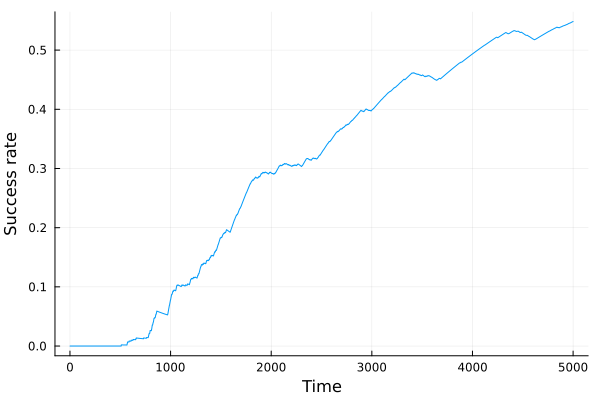

In [17]:
plot(success_rates, xlabel = "Time", ylabel = "Success rate", legend = false)

<b> Plot 2: </b> Value function surface.

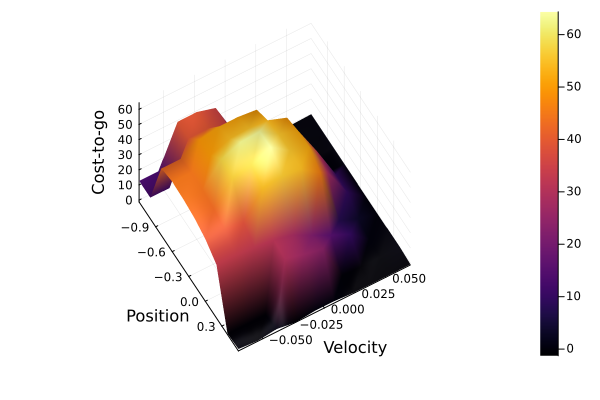

In [18]:
X = range(state_space(agent.env)[1].left,state_space(agent.env)[1].right,length = 10)
Y = range(state_space(agent.env)[2].left,state_space(agent.env)[2].right,length = 10)
Z = [maximum(agent.W * code((x,y),agent.tillings)) for x in X, y in Y];

plot(X,Y,-Z, st=:surface, camera = (60,60), xlabel = "Position", ylabel = "Velocity", zlabel = "Cost-to-go")

<b> Plot 3: </b> Successe rate as a function of time in validation mode.

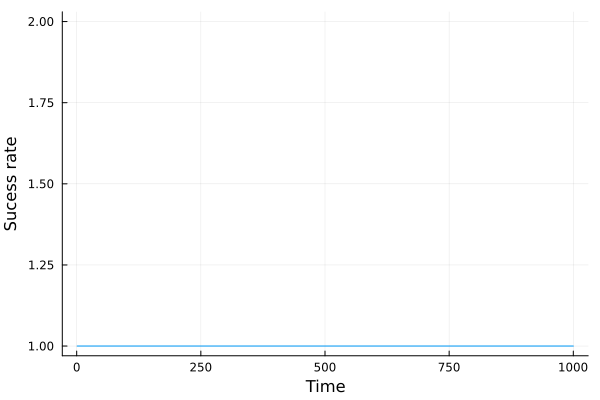

In [19]:
rewards,success_rates = run!(agent,1000; train = false, plotting = false, summary = false);
plot(success_rates, xlabel = "Time", ylabel = "Sucess rate", legend = false)